In [1]:
import cv2                                 
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

## Read in cat and dog training images

In [2]:
#load in cat data

cat_folder = os.listdir('../Data/folders/train/cat/')
categories = []

for filename in cat_folder:
    #binary classification
    categories.append(0)
        
cat_df = pd.DataFrame({
    'file': cat_folder,
    'category': categories
})

In [3]:
cat_df.shape

(12500, 2)

In [4]:
#load in dog data

dog_folder = os.listdir('../Data/folders/train/dog/')
categories = []

for filename in dog_folder:
    #binary classification
    categories.append(1)
        
dog_df = pd.DataFrame({
    'file': dog_folder,
    'category': categories
})

In [51]:
dog_df.shape

(12500, 2)

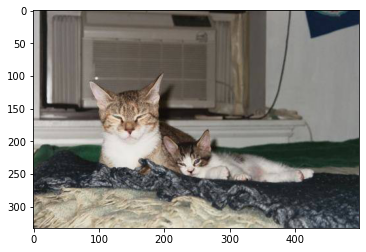

In [52]:
#Random cat
cat_samp = random.choice(cat_folder)
rand_cat = load_img('../Data/folders/train/cat/' + cat_samp)
plt.imshow(rand_cat);

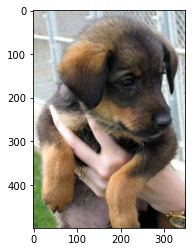

In [54]:
#Random dog
dog_samp = random.choice(dog_folder)
rand_dog = load_img('../Data/folders/train/dog/' + dog_samp)
plt.imshow(rand_dog);

In [9]:
#Combine DataFrames

df = pd.concat([cat_df, dog_df])

In [10]:
df.shape

(25000, 2)

In [11]:
df.head()

,file,category
0,cat.5077.jpg,0
1,cat.2718.jpg,0
2,cat.10151.jpg,0
3,cat.3406.jpg,0
4,cat.4369.jpg,0


In [12]:
X = df['file']
y = df['category']

## CNN modeling

In [13]:
#Measurements
WIDTH=250
HEIGHT=250
SIZE=(WIDTH, HEIGHT)


In [14]:
model = Sequential()

model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 248, 248, 128)     3584      
_________________________________________________________________
batch_normalization_4 (Batch (None, 248, 248, 128)     512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 124, 124, 128)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 124, 124, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 64)      73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 122, 122, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 64)       

In [39]:
earlystop = EarlyStopping(patience=12)
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=2, 
                                 min_lr=.00002)

callbacks = [earlystop, learning_rate]

In [40]:
#datagenerater later only works with strings/tuples
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 


In [41]:
#separating into two different dataframes
train, test = train_test_split(df, 
                               random_state=42,
                               test_size=.15,
                               shuffle=True)


In [42]:
train['category'].value_counts()

dog    10658
cat    10592
Name: category, dtype: int64

In [43]:
train_shape = train.shape[0]
test_shape = test.shape[0]
batch_size=16

In [44]:
# Data Generator works as a pipeline for bringing in the full file, adjusting, and manipulating for AI 
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1/255,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

#train
train_gen = train_data_gen.flow_from_dataframe(
    train, 
    '../Data/from_kaggle/train/', 
    x_col='file',
    y_col='category',
    target_size=SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 21250 validated image filenames belonging to 2 classes.


In [45]:
#test
test_data_gen = ImageDataGenerator(rescale=1./255)
test_gen = test_data_gen.flow_from_dataframe(
    test, 
    '../Data/from_kaggle/train/', 
    x_col='file',
    y_col='category',
    target_size=SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3750 validated image filenames belonging to 2 classes.


In [46]:
#test on one sample image
trial = train.sample(n=1).reset_index(drop=True)
trial_gen = train_data_gen.flow_from_dataframe(
    trial, 
    '../Data/from_kaggle/train/', 
    x_col='file',
    y_col='category',
    target_size=SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


<function matplotlib.pyplot.show(*args, **kw)>

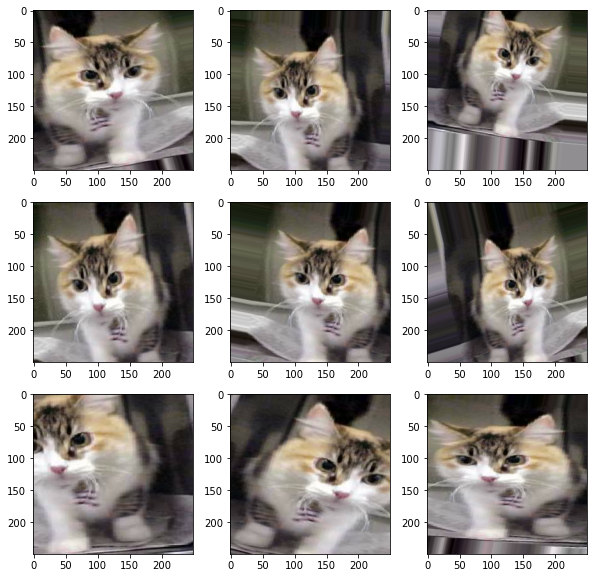

In [47]:
#Show trial image
plt.figure(figsize=(10, 10))

#visualize layout
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    #show image
    for x, y in trial_gen:
        image = x[0]
        plt.imshow(image)
        break

plt.show

In [70]:
history = model.fit(
    train_gen, 
    epochs=50,
    validation_data=test_gen,
    validation_steps=test_shape//batch_size,
    steps_per_epoch=train_shape//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1328/1328 [==============================] - 3150s 2s/step - loss: 0.7611 - accuracy: 0.5940 - val_loss: 0.6715 - val_accuracy: 0.6010
Epoch 2/50
1328/1328 [==============================] - 3164s 2s/step - loss: 0.6262 - accuracy: 0.6477 - val_loss: 0.7597 - val_accuracy: 0.6010
Epoch 3/50
1328/1328 [==============================] - 3129s 2s/step - loss: 0.5924 - accuracy: 0.6848 - val_loss: 0.5181 - val_accuracy: 0.7492
Epoch 4/50
1328/1328 [==============================] - 3054s 2s/step - loss: 0.5634 - accuracy: 0.7115 - val_loss: 0.4876 - val_accuracy: 0.7682
Epoch 5/50
1328/1328 [==============================] - 3073s 2s/step - loss: 0.5616 - accuracy: 0.7123 - val_loss: 0.5095 - val_accuracy: 0.7537
Epoch 6/50
1328/1328 [==============================] - 3092s 2s/step - loss: 0.5360 - accuracy: 0.7326 - val_loss: 0.5195 - val_accuracy: 0.7366
Epoch 7/50
1328/1328 [==============================] - 3069s 2s/step - loss: 0.4881 - accuracy: 0.7632 - val_loss: 0.4333 -

epoch 43
first run
loss: 0.2802 - accuracy: 0.8820 - val_loss: 0.2800 - val_accuracy: 0.8859

epoch 3 testing:
same model as above: loss: 0.5800 - accuracy: 0.7007

new 256 dense:
loss: 0.5593 - accuracy: 0.7142

add cov2d 32:
loss: 0.5325 - accuracy: 0.7380

add cov2d 32(full run):
loss: 0.3369 - accuracy: 0.8534 - val_loss: 0.3058 - val_accuracy: 0.8763

shape from 100x100 to 200x200:
loss: 0.3832 - accuracy: 0.8268 - val_loss: 0.2975 - val_accuracy: 0.8781

shape from 200x200 to 250x250, batch size 15 to 16:

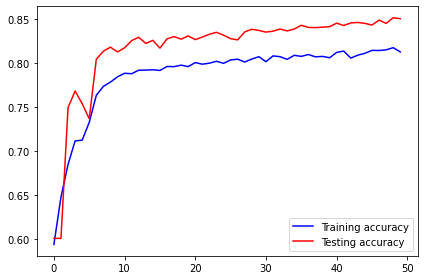

In [83]:
plt.plot(figsize=(12, 15))

plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Testing accuracy")

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show();

In [72]:
from tensorflow import keras
model.save('classification_model')

INFO:tensorflow:Assets written to: classification_model_50_epochs/assets
